<a href="https://colab.research.google.com/github/ManavFCB/Crowd-Counting/blob/master/CC_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from google.colab import drive
import pandas as pd
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


**Generate annotation maps**

In [ ]:
path = '/content/gdrive/MyDrive/nwpu/jsons'

In [ ]:
sigma = 15
sigma_1 = 15
fc = 0
s = "annotation_map_" + str(sigma)
s1 = "annotation_map_" + str(sigma_1)
for root, dirs, files in os.walk(path):
  print(root)
  for file in files:
    img_json = pd.read_json(os.path.join(root, file))
    img_name = file.split('.')[0]
    parent = root.split('/jsons')[0]
    fc += 1
    if fc % 100 == 0:
      print("the number of files processed:" + str(fc))
    if len(img_json) > 60 and img_json['human_num'].iloc[0] < 700: #larger numbers take time os.path.isfile(os.path.join(parent, s1, img_name + ".jpg"))
      if not os.path.isfile(os.path.join(parent, s, img_name + ".jpg")):
        print(file)
        img = cv2.imread(os.path.join(parent, img_name+'.jpg'), cv2.IMREAD_GRAYSCALE)
        annotations = img_json['points']
        annotation_map = np.zeros(img.shape, dtype = 'int')
        for annotation in annotations:
          x = int(annotation[0])
          y = int(annotation[1])
          annotation_map[y:y+10, x:x+10] = 255
          map = gaussian_filter(annotation_map, sigma = sigma, order = 0)
        if not os.path.isdir(os.path.join(parent, s)):
          print("created:"+os.path.join(parent, s))
          os.mkdir(os.path.join(parent, s))
        cv2.imwrite(os.path.join(parent, s, img_name + ".jpg"), map)
      else:
        continue
    else:
      continue

In [ ]:
path = '/content/gdrive/MyDrive/nwpu/'

In [ ]:
def region_division(image, patchsize_r, patchsize_c, train, img_json_df = None):
  #resize the image
  newsize = (640, 360)
  patch_tuples_r, patch_tuples_c, patch_list = [], [], []
  for i in range(patchsize_r):
    patch_tuple = (i * newsize[1] // patchsize_r, (i + 1) * newsize[1] // patchsize_r)
    patch_tuples_r.append(patch_tuple)

  for i in range(patchsize_c):
    patch_tuple = (i * newsize[0] // patchsize_c, (i + 1) * newsize[0] // patchsize_c)
    patch_tuples_c.append(patch_tuple)
  
  # generate patches for the annotation map
  for i in range(len(patch_tuples_r)):
    for j in range(len(patch_tuples_c)):
      image_patch = image[patch_tuples_r[i][0] : patch_tuples_r[i][1], patch_tuples_c[j][0] : patch_tuples_c[j][1]]
      image_patch = cv2.resize(image_patch, newsize)
      patch_list.append(image_patch)
  if train == True:
    x_ratio = 640 / image.shape[1]
    y_ratio = 360 / image.shape[0]
    image = cv2.resize(image, newsize)
    counts = region_count_generate(img_json_df, patch_tuples_r, patch_tuples_c, x_ratio, y_ratio)
    return patch_list, counts
  else:
    return patch_list

def region_count_generate(img_json_df, patch_tuples_r, patch_tuples_c, x_ratio, y_ratio):
  num_regions = len(patch_tuples_c) * len(patch_tuples_r)
  counts = [0] * num_regions
  for point in img_json_df['points']:
    flag = 0
    point[1] *= y_ratio
    point[0] *= x_ratio
    for i in range(len(patch_tuples_r)):
      for j in range(len(patch_tuples_c)):
        if patch_tuples_r[i][0] <= point[1] < patch_tuples_r[i][1]:
          if patch_tuples_c[j][0] <= point[0] < patch_tuples_c[j][1]:
            counts[len(patch_tuples_c)*i + j] += 1
  return counts

In [ ]:
# for testing purposes
# to preprocess training data before feeding to UNet and CNN (for training and prediction)
# if data is None, then it's for training else prediction; data represents the annotation map
def preprocess(data = None):
  first_sigma = 15
  second_sigma = 5
  s1 = "annotation_map_" + str(first_sigma)
  s2 = "annotation_map_" + str(second_sigma)
  fc = 0
  X_train, Y_train_annot_15, patch_lists, counts, full_im_counts = [], [], [], [], []
  if data == None:
    for root, dirs, files in os.walk(path):
      if root == '/content/gdrive/MyDrive/nwpu/':
        for file in files:
          img_path_15 = os.path.join(root, s1, file)
          if os.path.isfile(img_path_15) and fc < 1000:
            fc += 1
            print(img_path_15)
            train_img_path = os.path.join(root, file)
            file_name_json = file.split(".jpg")[0] + ".json"
            json_path = os.path.join(root, "jsons", file_name_json)
            json_df = pd.read_json(json_path)
            full_im_counts.append(json_df['human_num'].iloc[0])

            # img_path_5 = os.path.join(root, s2, file)

            train_img = cv2.imread(train_img_path, cv2.IMREAD_GRAYSCALE)
            train_img_resize = cv2.resize(train_img, (640, 360))
            X_train.append(train_img_resize)

            img_15_train = cv2.imread(img_path_15, cv2.IMREAD_GRAYSCALE)
            _, img_15_train = cv2.threshold(img_15_train, 0, 1, cv2.THRESH_BINARY)
            patch_list, count = region_division(img_15_train, 3, 4, True, json_df)
            counts.append(count)
            patch_lists.append(patch_list)
            img_15_train_resize = cv2.resize(img_15_train, (640, 360))
            Y_train_annot_15.append(img_15_train_resize)
    return X_train, Y_train_annot_15, patch_lists, counts, full_im_counts
  
  else:
    patch_lists_test = []
    for i in range(len(data)):
      patch_list = region_division(data, 3, 4, False)
      patch_lists_test.append(patch_list)
    return patch_lists_test

X_train, Y_train_annot_15, patch_lists, counts, full_im_counts = preprocess()

/content/gdrive/MyDrive/nwpu/annotation_map_15/0849.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/0919.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1208.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1443.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1471.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1821.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1945.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/2064.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/2232.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/2571.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/2746.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/3022.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/3160.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/3251.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/3480.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/0769.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/1127.jpg
/content/gdrive/MyDrive/nwpu/annotation_map_15/0

In [ ]:
X_train, Y_train_annot_15 = np.array(X_train), np.array(Y_train_annot_15)

In [ ]:
# flatten the array before feeding to CNNs

patch_lists = np.array(patch_lists)
patch_lists = patch_lists.reshape(patch_lists.shape[0] * patch_lists.shape[1], patch_lists.shape[2], patch_lists.shape[3])
counts = np.array(counts)
counts = counts.reshape(counts.shape[0] * counts.shape[1], )
full_im_counts = np.array(full_im_counts)

In [ ]:
class UNet:
  def conv(self,x, filters, down_kernel, kernel_size = (3, 3), padding = 'same', strides = 1):
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(x)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    m = tf.keras.layers.MaxPool2D(down_kernel)(b)
    return b, m

  # Function to define the bottleneck layer (last layer in Encoder)
  def bottleneck(self, x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(x)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    return b

  # helps with concatenating the upsampling and downsampled layers (smaller and larger respectively)
  # same number of pixels are cut from top and bottom. Likewise left and right
  def get_crop(self, c, u):
    height = c.shape[1] - u.shape[1]
    if height % 2 == 0:
      top_crop, bottom_crop = height // 2, height // 2
    else:
      top_crop, bottom_crop = int(height / 2), int(height / 2) + 1
    width = c.shape[2] - u.shape[2]
    if width % 2 == 0:
      left_crop, right_crop = width // 2, width // 2
    else:
      left_crop, right_crop = int(width // 2), int(width // 2) + 1
    
    return (top_crop, bottom_crop), (left_crop, right_crop)


  # Function to upsample, concatenate and convolve (Decoding layer)
  def upconv(self, x, skip, filters, up_kernel, kernel_size = (3, 3), padding = 'same', strides = 1):
    ups = tf.keras.layers.Conv2DTranspose(filters, (2, 2), padding = padding, strides = up_kernel)(x)
    height, width = self.get_crop(skip, ups)
    skip = tf.keras.layers.Cropping2D(cropping = (height, width))(skip)
    concat = tf.keras.layers.Concatenate(axis = 3)([ups, skip])
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(concat)
    c = tf.keras.layers.Convolution2D(filters, kernel_size, strides, activation = 'relu', padding = padding)(c)
    b = tf.keras.layers.BatchNormalization()(c)
    return b

  # Function to build the UNet Model
  def build(self):
    filters = [64, 128, 256, 512, 1024]
    kernel = [2, 5]
    input = tf.keras.layers.Input((360, 640))
    reshape = tf.keras.layers.Reshape((360, 640, 1))(input)
    bn = tf.keras.layers.BatchNormalization()(reshape)
    c1, m1 = self.conv(bn, filters[0], kernel[0])
    c2, m2 = self.conv(m1, filters[1], kernel[0])
    c3, m3 = self.conv(m2, filters[2], kernel[0])
    c4, m4 = self.conv(m3, filters[3], kernel[1])
    c5 = self.bottleneck(m4, filters[4])
    u1 = self.upconv(c5, c4, filters[3], kernel[1])
    u2 = self.upconv(u1, c3, filters[2], kernel[0])
    u3 = self.upconv(u2, c2, filters[1], kernel[0])
    u4 = self.upconv(u3, c1, filters[0], kernel[0])
    out = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid', dtype = 'float32')(u4)
    out = tf.keras.layers.Reshape((360, 640))(out)
    return tf.keras.Model(input, out)

In [ ]:
def loss(y_true, y_pred):
  l = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred, tf.keras.losses.Reduction.SUM) + 1 - tf.reduce_sum(tf.image.ssim(y_true, y_pred, 255.0))
  return l

def build_and_train_unets(num_models, x_train, y_train):
  models = [0] * num_models # a list for multiple models
  for i in range(num_models):
    unet = UNet()
    models[i] = unet.build()
    models[i].compile(optimizer = 'adam', loss = loss)
    models[i].train(1, x_train, y_train)
    models[i].save('/content/gdrive/MyDrive/nwpu/unet_360x640_'+str(i)+'.h5')

In [ ]:
# predict with save model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/nwpu/unet_360x640.h5')

In [ ]:
preds = model.predict(X_test)
preds *= 255
preds = preds.astype('uint8')
for i in range(len(preds)):
  _, preds[i] = cv2.threshold(preds[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

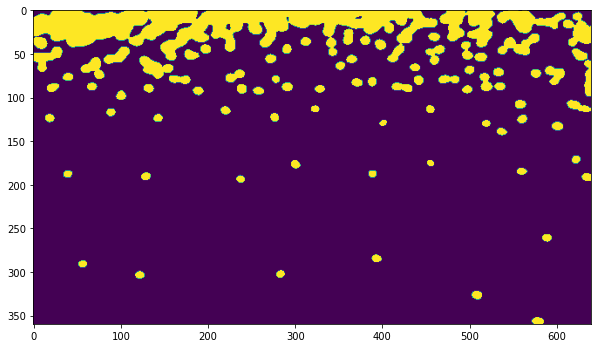

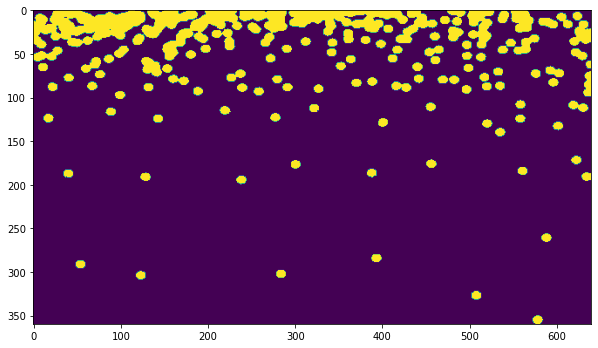

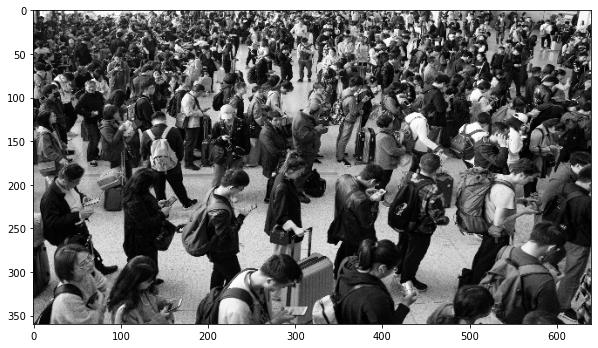

In [ ]:
a = preds[801]
plt.figure(figsize = (10, 20))
plt.imshow(a)
plt.figure(figsize  = (10, 20))
plt.imshow(Y_test_annot_15[801])
plt.figure(figsize = (10, 20))
plt.imshow(X_test[801], cmap = 'gray')

**Region Division**

**code to generate counts per region**

In [ ]:

def build_and_train_models(num_models, y_train, gt_train_list):
  models, histories = [0] * num_models, [0] * num_models
  for i in range(num_models):
    models[i] = tf.keras.models.load_model('/content/gdrive/MyDrive/fdst/densitytogtbesttrain.h5')
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    models[i].compile(optimizer = optimizer, loss = 'mse')
    epochs = 500
    histories[i] = models[i].fit(y_train, np.array(gt_train_list, dtype = 'float32'), batch_size = 64, epochs = epochs, shuffle = True)
    histories[i] = histories[i].history['loss'][-1]       # extract only the loss score obtained in the last epoch for each model
    return models, histories
  
# make test predictions such that models are weighed based on their loss estimates.
def predict(y_test, models, histories):
  preds = []
  for i in range(len(models)):
    mod_preds = models[i].predict(y_test)
    mod_preds = mod_preds.reshape(len(mod_preds) // 12, 12)  #every 12 contiguous regions make up a full image.
    mod_preds = np.sum(mod_preds, axis = 1) #summing the counts per batch of 12 gives the total count per full image
    preds.append(mod_preds)
  preds = np.array(mod_preds)
  scores = 1.0 / np.array(histories)    # models with lesser mse are given higher weights.
  final_preds = np.dot(scores, preds) / np.sum(scores)    # weighted average of the predictions
  return preds

In [ ]:
models, histories = build_and_train_models(1, Y_train_annot_15, full_im_counts)

Epoch 1/500
16/16 [==============================] - 5s 278ms/step - loss: 42476.6506
Epoch 2/500
16/16 [==============================] - 4s 278ms/step - loss: 14994.6308
Epoch 3/500
16/16 [==============================] - 4s 277ms/step - loss: 12944.7930
Epoch 4/500
16/16 [==============================] - 4s 277ms/step - loss: 9310.7781
Epoch 5/500
16/16 [==============================] - 4s 277ms/step - loss: 8132.8536
Epoch 6/500
16/16 [==============================] - 4s 277ms/step - loss: 6696.4695
Epoch 7/500
16/16 [==============================] - 4s 278ms/step - loss: 5248.6174
Epoch 8/500
16/16 [==============================] - 4s 278ms/step - loss: 4608.1347
Epoch 9/500
16/16 [==============================] - 4s 278ms/step - loss: 2735.3757
Epoch 10/500
16/16 [==============================] - 4s 278ms/step - loss: 2350.4029
Epoch 11/500
16/16 [==============================] - 4s 278ms/step - loss: 2064.1868
Epoch 12/500
16/16 [==============================] - 4s 278

In [ ]:
s = models[0].predict(Y_test_annot_15, models, histories)

In [ ]:
s = np.reshape(s, (s.shape[0], ))

(array([  1.,   2.,  18.,  27., 104., 293., 413., 102.,  22.,  18.]),
 array([-28.92874146, -23.89345398, -18.8581665 , -13.82287903,
         -8.78759155,  -3.75230408,   1.2829834 ,   6.31827087,
         11.35355835,  16.38884583,  21.4241333 ]),
 <a list of 10 Patch objects>)

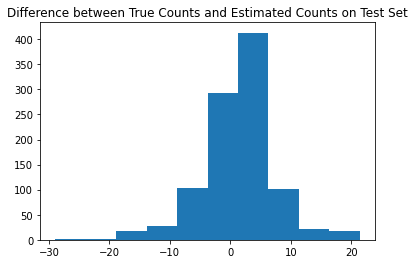

In [ ]:
plt.title("Difference between True Counts and Estimated Counts on Test Set")
plt.hist(diff)

1.2564123139508419


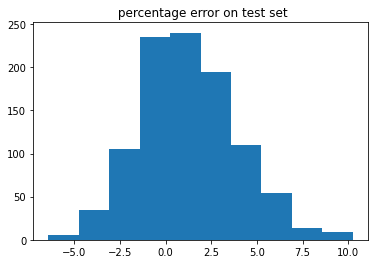

In [ ]:
plt.title(" percentage error on test set")
plt.hist(percent)
print(np.mean(percent))

In [ ]:
cnn.models[0].save('/content/gdrive/MyDrive/fdst/densitytogtbesttrain.h5')    ##DONT RUN AGAIN!!!!!!! WILL LOSE BEST MODEL

In [ ]:
mod = tf.keras.models.load_model('/content/gdrive/MyDrive/fdst/densitytogtbesttrain.h5')